In [5]:
import sys
#sys.path.insert(0, '/home/jovyan/work/Molecular_Properties/model-pipeline/src')
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from model_construction import prepare_data_split, run_model, show_varimp
from bearinmind_pipeline.data_preprocessing import dataPreprocessing as dp
#from bearinmind_pipeline.model_construction import modelBuilder as mb
import bearinmind_pipeline.model_construction as mc
from numpy import inf
from sklearn.metrics import mean_squared_error
from math import sqrt
import gc
from tqdm import tqdm_notebook, tqdm 
import matplotlib.pyplot as plt
import datetime
import json
from scipy import stats
import holidays
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Using TensorFlow backend.


In [199]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
mapping = pd.read_csv('./data/building_metadata.csv')

In [200]:
weather_train = pd.read_csv('./data/weather_train.csv')
weather_test = pd.read_csv('./data/weather_test.csv')

In [201]:
### Add Holidays ###
def get_holidays(df):
    en_holidays = holidays.England()
    ir_holidays = holidays.Ireland()
    ca_holidays = holidays.Canada()
    us_holidays = holidays.UnitedStates()
    en_idx = df.query('site_id == 1 or site_id == 5').index
    ir_idx = df.query('site_id == 12').index
    ca_idx = df.query('site_id == 7 or site_id == 11').index
    us_idx = df.query('site_id == 0 or site_id == 2 or site_id == 3 or site_id == 4 or site_id == 6 or site_id == 8 or site_id == 9 or site_id == 10 or site_id == 13 or site_id == 14 or site_id == 15').index
    df['IsHoliday'] = 0
    df.loc[en_idx, 'IsHoliday'] = df.loc[en_idx, 'timestamp'].apply(lambda x: en_holidays.get(x, default=0))
    df.loc[ir_idx, 'IsHoliday'] = df.loc[ir_idx, 'timestamp'].apply(lambda x: ir_holidays.get(x, default=0))
    df.loc[ca_idx, 'IsHoliday'] = df.loc[ca_idx, 'timestamp'].apply(lambda x: ca_holidays.get(x, default=0))
    df.loc[us_idx, 'IsHoliday'] = df.loc[us_idx, 'timestamp'].apply(lambda x: us_holidays.get(x, default=0))
    holiday_idx = df['IsHoliday'] != 0
    df.loc[holiday_idx, 'IsHoliday'] = 1
    df['IsHoliday'] = df['IsHoliday'].astype(np.uint8)
    
    return df

In [202]:
weather_train = get_holidays(weather_train)
weather_test = get_holidays(weather_test)

In [203]:
timediff = {0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4}
weather_train['timediff']= weather_train['site_id'].map(timediff)
weather_test['timediff']= weather_test['site_id'].map(timediff)

weather_train['timediff'] = weather_train['timediff'].apply(lambda x: datetime.timedelta(hours=x))
weather_test['timediff'] = weather_test['timediff'].apply(lambda x: datetime.timedelta(hours=x))

weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp']) 
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

weather_train['timestamp'] = weather_train['timestamp'] - weather_train['timediff']
weather_test['timestamp'] = weather_test['timestamp'] - weather_test['timediff']

In [204]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,timediff
0,0,2015-12-31 20:00:00,25.000,6.000,20.000,nan,1019.700,0.000,0.000,1,04:00:00
1,0,2015-12-31 21:00:00,24.400,nan,21.100,-1.000,1020.200,70.000,1.500,1,04:00:00
2,0,2015-12-31 22:00:00,22.800,2.000,21.100,0.000,1020.200,0.000,0.000,1,04:00:00
3,0,2015-12-31 23:00:00,21.100,2.000,20.600,0.000,1020.100,0.000,0.000,1,04:00:00
4,0,2016-01-01 00:00:00,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1,04:00:00


In [205]:
df_train = df_train.merge(mapping, how = "left", on = "building_id")
df_test = df_test.merge(mapping, how = "left", on = "building_id")

In [207]:
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

In [208]:
df_train = df_train.merge(weather_train, how = "left", on = ["site_id", "timestamp"])
df_test = df_test.merge(weather_test, how = "left", on =  ["site_id", "timestamp"])

In [157]:
del weather_train 
del weather_test

In [211]:
df_train = df_train.drop(['timediff'], axis = 1)
df_test = df_test.drop(['timediff'], axis = 1)

In [213]:
def rmsle(y, yhat):
    score = np.sqrt(np.mean(np.power(np.log(yhat+1)-np.log(y.reset_index(drop=True)+1), 2)))
    return(score)

In [123]:
# Check one building
df_train_build = df_train[(df_train['building_id'] == 46) & (df_train['meter'] == 0)]

In [214]:
### Intrapolate cloud coverage
df_train['cloud_coverage'] = df_train.groupby(['building_id', 'meter'])['cloud_coverage'].apply(lambda x : x.interpolate(method = "spline", order = 1,limit_direction = "both", limit = 1000))
df_test['cloud_coverage'] = df_test.groupby(['building_id', 'meter'])['cloud_coverage'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both", limit = 1000))

In [ ]:
### Intrapolate air temperature
df_train['air_temperature'] = df_train.groupby(['building_id', 'meter'])['air_temperature'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))
df_test['air_temperature'] = df_test.groupby(['building_id', 'meter'])['air_temperature'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))

In [ ]:
df_train.head()

In [ ]:
#### Take a Sample ####
#df_train = df_train.sample(n=int(df_train.shape[0]*0.1), random_state=1)
#df_test = df_test.sample(n=int(df_test.shape[0]*0.1), random_state=1)

In [ ]:
#df_train["Month"] = pd.to_datetime(df_train["timestamp"]).dt.month
#df_test["Month"] = pd.to_datetime(df_test["timestamp"]).dt.month

In [ ]:
df_train["Day"] = pd.to_datetime(df_train["timestamp"]).dt.day
df_test["Day"] = pd.to_datetime(df_test["timestamp"]).dt.day

In [ ]:
df_train["Hour"] = pd.to_datetime(df_train["timestamp"]).dt.hour
df_test["Hour"] = pd.to_datetime(df_test["timestamp"]).dt.hour

In [ ]:
#df_train.to_csv("df_train.csv", index = False)
#df_test.to_csv("df_test.csv", index = False)

In [ ]:
#df_train = pd.read_csv('./df_train.csv')
#df_test = pd.read_csv('./df_test.csv')

In [ ]:
plt.plot(pd.to_datetime(df_train[(df_train['building_id']==0) & (df_train['meter']==0)]['timestamp']).dt.date, df_train[(df_train['building_id']==0) & (df_train['meter']==0)]['precip_depth_1_hr'])

In [ ]:
df_train['precip_depth_1_hr'] = df_train.groupby(['building_id', 'meter'])['precip_depth_1_hr'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['precip_depth_1_hr'] = df_test.groupby(['building_id', 'meter'])['precip_depth_1_hr'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['sea_level_pressure'] = df_train.groupby(['building_id', 'meter'])['sea_level_pressure'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['sea_level_pressure'] = df_test.groupby(['building_id', 'meter'])['sea_level_pressure'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['wind_direction'] = df_train.groupby(['building_id', 'meter'])['wind_direction'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['wind_direction'] = df_test.groupby(['building_id', 'meter'])['wind_direction'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['wind_speed'] = df_train.groupby(['building_id', 'meter'])['wind_speed'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['wind_speed'] = df_test.groupby(['building_id', 'meter'])['wind_speed'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['dew_temperature'] = df_train.groupby(['building_id', 'meter'])['dew_temperature'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['dew_temperature'] = df_test.groupby(['building_id', 'meter'])['dew_temperature'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train["DayOfWeek"] = pd.to_datetime(df_train["timestamp"]).dt.dayofweek
df_test["DayOfWeek"] = pd.to_datetime(df_test["timestamp"]).dt.dayofweek

In [ ]:
df_train.head()

In [ ]:
#df_train = dp.create_stats_features(df_train, 'dew_temperature', ['site_id', 'Month'])
#df_test = dp.create_stats_features(df_test, 'dew_temperature', ['site_id', 'Month'])

In [ ]:
#df_train["air_temperature_log"] = np.log(df_train['air_temperature'])
#df_test["air_temperature_log"] = np.log(df_test['air_temperature'])

In [ ]:
#df_train["Age"] = pd.to_datetime(df_train["timestamp"]).dt.year - df_train["year_built"]
#df_test["Age"] = pd.to_datetime(df_test["timestamp"]).dt.year - df_test["year_built"]

In [ ]:
### Clean Electricity ###
df_train = df_train[~((df_train['site_id'] == 0) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-05-20 18:00:00')))]

In [ ]:
df_train = df_train[~((df_train['building_id'] == 799) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-06-01 12:00:00')))]
df_train = df_train[~((df_train['building_id'] == 802) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-23 08:00:00')))]
df_train = df_train[~((df_train['building_id'] == 803) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-24 20:00:00')))]

In [237]:
df_train.to_csv("df_train.csv.gz", index = False, compression = 'gzip')
df_test.to_csv("df_test.csv.gz", index = False, compression = 'gzip')

In [159]:
df_train = pd.read_csv('./df_train.csv.gz', compression = 'gzip')
df_test = pd.read_csv('./df_test.csv.gz', compression = 'gzip')

In [160]:
### Lags for cloud coverage and air temperature
#for i in range(12):
#    df_train[f'cloud_coverage_lag{i+1}'] = df_train.groupby(['building_id', 'meter'])['cloud_coverage'].shift(i+1)
#    df_test[f'cloud_coverage_lag{i+1}'] = df_test.groupby(['building_id', 'meter'])['cloud_coverage'].shift(i+1)
#    df_train[f'air_temperature_lag{i+1}'] = df_train.groupby(['building_id', 'meter'])['air_temperature'].shift(i+1)
#    df_test[f'air_temperature_lag{i+1}'] = df_test.groupby(['building_id', 'meter'])['air_temperature'].shift(i+1)

In [161]:
### Drop zero values in Electricity ###
df_train = df_train.drop(df_train[(df_train['meter'] == 0) 
                       & (df_train['meter_reading'] == 0.0)].index)

In [162]:
### Log of Square fit plus year build ###
#df_train['year_built'] = df_train['year_built'] - 1900
#df_train['square_feet'] = np.log(df_train['square_feet'])
#df_test['year_built'] = df_test['year_built'] - 1900
#df_test['square_feet'] = np.log(df_test['square_feet'])

In [163]:
def roll_diff(x):
    return x[-1] - x[0]

In [164]:
def check_constants(grp):
    grp['is_constant_meter'] = grp['meter_reading'].rolling(2).apply(roll_diff)
    return grp

In [165]:
# calculate rolling diff for constant detection
df_train = df_train.groupby(['building_id', 'meter'], as_index = False).apply(lambda x: check_constants(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [166]:
df_train.shape

(19682552, 21)

In [167]:
# convert constant meter readings to nan
df_train.loc[df_train['is_constant_meter'] == 0.0, 'meter_reading'] = np.nan

In [168]:
df_train['meter_reading'].isnull().sum()

2805009

In [ ]:
test = df_train.copy()

In [ ]:
# Intrapolate nan values of meter reading 
test['meter_reading'] = test.groupby(['building_id', 'meter'])['meter_reading'].apply(lambda x : x.interpolate(method = "spline", order = 2, limit_direction = "both"))

In [ ]:
test['meter_reading'].isnull().sum()

In [ ]:
test_viz = df_train[(df_train['meter'] ==  1) & (df_train['building_id'] == 7)] 

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(pd.to_datetime(test_viz["timestamp"]).dt.date, test_viz['meter_reading'])

In [146]:
################ Manual check of singe buildings ##################
df_train_elec = df_train[(df_train['site_id'] == 0) & (df_train['meter'] == 1)] 
df_train_elec_test = df_train_elec[df_train_elec['building_id'] == 753]

In [147]:
df_train_elec.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,is_constant_meter
3022992,7,1,2016-02-29 09:00:00,1857.260,0,Education,121074,1989.000,nan,13.300,9.635,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022993,9,1,2016-02-29 09:00:00,590.945,0,Office,27000,2010.000,nan,13.300,9.347,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022994,13,1,2016-02-29 09:00:00,1224.100,0,Education,99380,2000.000,nan,13.300,7.035,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022995,14,1,2016-02-29 09:00:00,1435.150,0,Education,86250,2013.000,nan,13.300,9.731,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022996,15,1,2016-02-29 09:00:00,422.104,0,Office,83957,1974.000,nan,13.300,9.731,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan


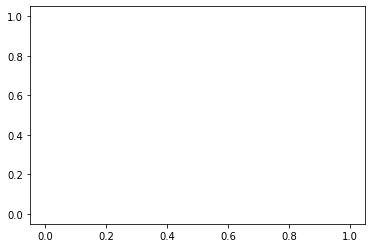

In [148]:
z = np.abs(stats.zscore(df_train_elec['meter_reading']))
#pd.Series(z).describe()
plt.plot(z)

In [149]:
df_train_elec['building_id'].unique()

array([  7,   9,  13,  14,  15,  29,  30,  31,  43,  50,  55,  60,  75,
        76,  78,  82,  91,  92,  95,  96,  97, 103,  28,  98])

In [150]:
#test = df_train_elec.groupby('building_id', as_index=False).apply(lambda x: x[(np.abs(stats.zscore(x['meter_reading'])) < 5)])
#df_train_elec_test[(np.abs(stats.zscore(df_train_elec_test['meter_reading'])) < 5)]
#test.shape

In [151]:
df_train_elec = df_train[(df_train['meter'] ==  1) & (df_train['building_id'] == 7)] 

In [152]:
#df_train_elec[pd.to_datetime(df_train_elec['timestamp']) > pd.to_datetime('2016-09-24 20:00:00')]

In [153]:
#df_train_elec['building_id'].nunique()

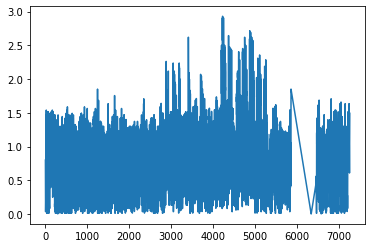

In [154]:
z = np.abs(stats.zscore(df_train_elec['meter_reading']))
#pd.Series(z).describe()
plt.plot(z)

In [155]:
#df_train_elec[pd.to_datetime(df_train_elec['timestamp']) > pd.to_datetime('2016-05-20 17:00:00')].head(30) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


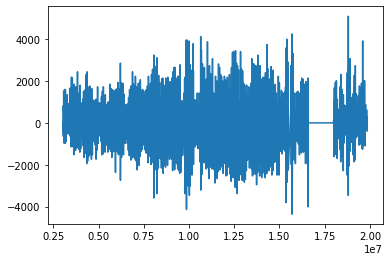

In [156]:
plt.plot(df_train_elec['meter_reading'].rolling(2).apply(roll_diff))

In [157]:
df_train_elec['meter_reading'].isna().sum()

0

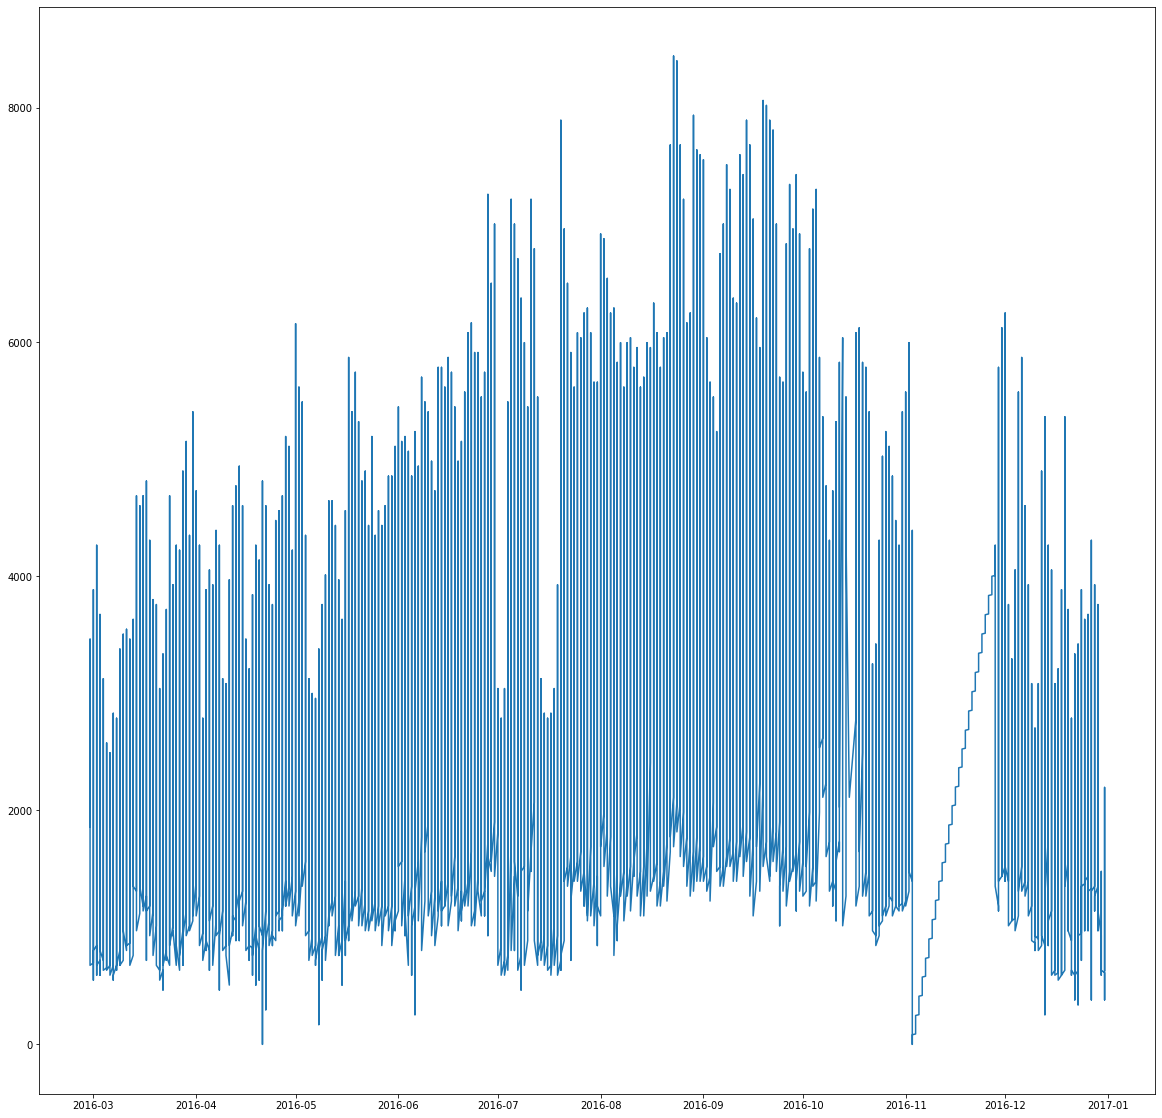

In [158]:
plt.figure(figsize=(20,20))
plt.plot(pd.to_datetime(df_train_elec["timestamp"]).dt.date, df_train_elec['meter_reading'])

In [879]:
#df_train = df_train[df_train["meter_reading"] != 0.0]

In [880]:
#encode_cols = ["primary_use"]

In [881]:
#data = dp.encode_categorical(df_train, df_test, encode_cols) 

In [882]:
#mb = mc.modelBuilder('regression', 'LGBM')

In [883]:
#data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
#                             target = 'meter_reading', rem_cols = ['timestamp'], 
#                             useVarImp = False, varimp_threshold = 100)

In [884]:
#data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)

In [101]:
#data['Y'] = np.log(data['Y'])

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [102]:
#data['Y'][data['Y'] == -inf] = 0

In [1]:
#data['Y'].describe()

NameError: name 'data' is not defined

In [5]:
def rmse(y, yhat):
    score = sqrt(mean_squared_error(y, yhat))
    return(score)

In [30]:
# LGBM
params = {
    'boosting_type':'gbdt',
    'n_estimators':500,
    'num_leaves':64, 
    'objective':'regression_l2', 
    'colsample_bytree': 1.0, 
    'learning_rate': 0.1,
    'max_bin':255, 
    'max_depth':9, 
    'metric':'rmse', 
    'min_child_samples':10,
    'min_child_weight':5, 
    'min_split_gain':0.0,
    'random_state':1234,
    'lambda_l2': 1.5,
    'verbose' : 2,
    #'reg_alpha':0.0,
    #'reg_lambda':0.0, 
    #'silent':True, 
    'subsample':1.0
    #,
    #'early_stopping_round' : 100
}

In [10]:
### CatBoost params
params = {
    'iterations':500,
    'learning_rate' : 0.3,
    'depth' : 9,
    'loss_function' : 'RMSE',
    'verbose' : 2,
    'eval_metric': 'RMSE',
}

In [11]:
#gc.collect()

In [12]:
#df_train_build = df_train[(df_train['building_id'] == 46) & (df_train['meter'] == 0)]

In [13]:
#df_train_build.head(20)

In [14]:
#submit = mb.run_model(data, n_folds = 5, metric_func = rmse, get_probab = False, 
#                      save_varimp = True, params = params, oversmp = False, cv_shuffle=False)

In [15]:
### Per site and meter type ###
perf_dict = {}
final_sub_lst = []
encode_cols = ["primary_use"]
mb = mc.modelBuilder('regression', 'CatBoost')
for i in tqdm_notebook(df_train['site_id'].unique()):
#for i in tqdm_notebook(range(7, 8, 1)):
    print(f'training site_id {i}')
    
    df_train_site = df_train[df_train['site_id'] == i]
    df_test_site = df_test[df_test['site_id'] == i]
    
    for j in df_train_site['meter'].unique():
        
        print(f'training meter {j}')
        df_train_metr = df_train_site[df_train_site['meter'] == j]
        df_test_metr = df_test_site[df_test_site['meter'] == j]

        df_train_metr = df_train_metr[(np.abs(stats.zscore(df_train_metr['meter_reading'])) < 5)]
        #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[(np.abs(stats.zscore(x['meter_reading'])) < 5)])
        #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[x['meter_reading'] < x['meter_reading'].quantile(0.99)])
        
        data = dp.encode_categorical(df_train_metr, df_test_metr, encode_cols)
        data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
                                 target = 'meter_reading', rem_cols = ['timestamp'], 
                                 useVarImp = False, varimp_threshold = 100)
        data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
        data['Y'] = np.log(data['Y'])
        data['Y'][data['Y'] == -inf] = 0
        submit = mb.run_model(data, n_folds = 3, metric_func = rmse, get_probab = False, 
                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False)
        submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
        final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

        perf_dict[f'site_id: {i} and meter: {j}'] = submit['AverageScore']
        final_sub_lst.append(final_submit)
    

training site_id 1
training meter 0
colums primary_use is being encoded
18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.9420162486385163
Fold: 1
The valuation metric for the fold 1 is 0.797262334582619
Fold: 2
The valuation metric for the fold 2 is 1.155281405051027
The average score accross the folds is 0.964853329424054
training meter 3
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.844298919396906
Fold: 1
The valuation metric for the fold 1 is 1.793701948571765
Fold: 2
The valuation metric for the fold 2 is 2.024955267796284
The average score accross the folds is 1.887652045254985
training site_id 2
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.5273558495494841
Fold: 1
The valuation metric for the fold 1 is 0.3583603172573492
Fold: 2
The valuation metric for the fold 2 is 0.41430999381306527
The average score accross the folds is 0.4333420535399662
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 1.4141310594543426
Fold: 1
The valuation metric for the fold 1 is 1.2663727810894252
Fold: 2
The valuation metric for the fold 2 is 1.3549482770016879
The average score accross the folds is 1.345150705848485
training meter 3
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.2442378250932782
Fold: 1
The valuation metric for the fold 1 is 0.8460830169919841
Fold: 2
The valuation metric for the fold 2 is 1.1518343143724465
The average score accross the folds is 1.0807183854859028
training site_id 3
training meter 0
colums primary_use is being encoded
18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.5738108830977213
Fold: 1
The valuation metric for the fold 1 is 0.444200198023505
Fold: 2
The valuation metric for the fold 2 is 0.5252271826061716
The average score accross the folds is 0.5144127545757994
training site_id 4
training meter 0
colums primary_use is being encoded
18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.25391358645272977
Fold: 1
The valuation metric for the fold 1 is 0.28429377379589377
Fold: 2
The valuation metric for the fold 2 is 0.27133093895784755
The average score 

/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.34366353752027745
Fold: 1
The valuation metric for the fold 1 is 0.3820665725359372
Fold: 2
The valuation metric for the fold 2 is 0.38342245816381443
The average score accross the folds is 0.36971752274000963
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.1976818292716396
Fold: 1
The valuation metric for the fold 1 is 1.3811996656295842
Fold: 2
The valuation metric for the fold 2 is 2.0632725298031587
The average score accross the folds is 1.880718008234794
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.6519970926848884
Fold: 1
The valuation metric for the fold 1 is 1.9740902008132477
Fold: 2
The valuation metric for the fold 2 is 1.8921355798063137
The average score accross the folds is 1.8394076244348165
training site_id 7
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.3048530585491562
Fold: 1
The valuation metric for the fold 1 is 1.6571502201841706
Fold: 2
The valuation metric for the fold 2 is 1.6415929543581804
The average score accross the folds is 1.5345320776971692
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.6656318098796385
Fold: 1
The valuation metric for the fold 1 is 1.6115008014933594
Fold: 2
The valuation metric for the fold 2 is 1.8625672580560044
The average score accross the folds is 1.7132332898096674
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3564430341189027
Fold: 1
The valuation metric for the fold 1 is 0.8161905551417997
Fold: 2
The valuation metric for the fold 2 is 2.044491543154157
The average score accross the folds is 1.0723750441382867
training meter 3
colums primary_use is being encoded
18 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 1.4765164168619829
Fold: 1
The valuation metric for the fold 1 is 2.656086450974191
Fold: 2
The valuation metric for the fold 2 is 2.137383725754394
The average score accross the folds is 2.089995531196856
training site_id 8
training meter 0
colums primary_use is being encoded
18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.7533487148412764
Fold: 1
The valuation metric for the fold 1 is 0.7231438769657753
Fold: 2
The valuation metric for the fold 2 is 0.6969229812209625
The average score accross the folds is 0.7244718576760047
training site_id 9
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 1.376988986182352
Fold: 1
The valuation metric for the fold 1 is 1.4532214910665793
Fold: 2
The valuation metric for the fold 2 is 1.5637234409089853
The average score accross the folds is 1.4646446393859722
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 1.5681867145571322
Fold: 1
The valuation metric for the fold 1 is 1.4753101139586378
Fold: 2
The valuation metric for the fold 2 is 1.5355838285511636
The average score accross the folds is 1.5263602190223111
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.27559743870313075
Fold: 1
The valuation metric for the fold 1 is 0.22699136614458268
Fold: 2
The valuation metric for the fold 2 is 0.2755536461250329
The average score accross the folds is 0.2593808169909155
training site_id 10
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.49735220282707987
Fold: 1
The valuation metric for the fold 1 is 0.43523223182813986
Fold: 2
The valuation metric for the fold 2 is 0.5177342864335555
The average score accross the folds is 0.4834395736962584
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.1316401653595576
Fold: 1
The valuation metric for the fold 1 is 1.740764250030281
Fold: 2
The valuation metric for the fold 2 is 1.9823775558802887
The average score accross the folds is 1.951593990423376
training meter 3
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.2895070809116254
Fold: 1
The valuation metric for the fold 1 is 2.187270858286707
Fold: 2
The valuation metric for the fold 2 is 2.324665480793803
The average score accross the folds is 2.267147806664045
training site_id 11
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.22348313950659668
Fold: 1
The valuation metric for the fold 1 is 0.3955571775521258
Fold: 2
The valuation metric for the fold 2 is 0.27720943067561876
The average score accross the folds is 0.2987499159114471
training meter 3
colums primary_use is being encoded
18 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.817292363333711
Fold: 1
The valuation metric for the fold 1 is 1.387107062984704
Fold: 2
The valuation metric for the fold 2 is 1.1849382873499688
The average score accross the folds is 1.129779237889461
training meter 1
colums primary_use is being encoded
18 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.46143706529638356
Fold: 1
The valuation metric for the fold 1 is 1.8347595176348683
Fold: 2
The valuation metric for the fold 2 is 1.2110018018750137
The average score accross the folds is 1.1690661282687553
training site_id 12
training meter 0
colums primary_use is being encoded
18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3155973758346314
Fold: 1
The valuation metric for the fold 1 is 0.34533372695927794
Fold: 2
The valuation metric for the fold 2 is 0.3240615405860692
The average score accross the folds is 0.3283308811266595
training site_id 13
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3374083418849017
Fold: 1
The valuation metric for the fold 1 is 0.3749803836446295
Fold: 2
The valuation metric for the fold 2 is 0.3746272571038546
The average score accross the folds is 0.36233866087779526
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 1.1962946469172604
Fold: 1
The valuation metric for the fold 1 is 1.0615239324826233
Fold: 2
The valuation metric for the fold 2 is 1.1422961878747588
The average score accross the folds is 1.1333715890915477
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 1.686434120566444
Fold: 1
The valuation metric for the fold 1 is 1.801411735636096
Fold: 2
The valuation metric for the fold 2 is 1.7646560849039359
The average score accross the folds is 1.7508339803688253
training site_id 14
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3441197580497938
Fold: 1
The valuation metric for the fold 1 is 0.29783122465716605
Fold: 2
The valuation metric for the fold 2 is 0.32801547479118776
The average score accross the folds is 0.3233221524993825
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.9582762564438059
Fold: 1
The valuation metric for the fold 1 is 1.8127253587450904
Fold: 2
The valuation metric for the fold 2 is 2.0694645177278437
The average score accross the folds is 1.94682204430558
training meter 3
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.279888382037137
Fold: 1
The valuation metric for the fold 1 is 1.7674930169562024
Fold: 2
The valuation metric for the fold 2 is 2.221976317311003
The average score accross the folds is 2.089785905434781
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.0266182242233093
Fold: 1
The valuation metric for the fold 1 is 1.5732785077277576
Fold: 2
The valuation metric for the fold 2 is 2.221548476688578
The average score accross the folds is 1.940481736213215
training site_id 15
training meter 3
colums primary_use is being encoded
18 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The valuation metric for the fold 0 is 0.7420624107999052
Fold: 1
The valuation metric for the fold 1 is 0.745725284772246
Fold: 2
The valuation metric for the fold 2 is 0.7068588437283534
The average score accross the folds is 0.7315488464335015
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.28460153527231946
Fold: 1
The valuation metric for the fold 1 is 0.2953157920498362
Fold: 2
The valuation metric for the fold 2 is 0.27565944559383104
The average score accross the folds is 0.28519225763866224
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.715475550114852
Fold: 1
The valuation metric for the fold 1 is 0.6348392606442992
Fold: 2
The valuation metric for the fold 2 is 0.6855353345140172
The average score accross the folds is 0.6786167150910561
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.1010121397474275
Fold: 1
The valuation metric for the fold 1 is 1.2316372427997773
Fold: 2
The valuation metric for the fold 2 is 0.9225884513058671
The average score accross the folds is 1.0850792779510239
training site_id 0
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.249569724641385
Fold: 1
The valuation metric for the fold 1 is 1.9852794419867386
Fold: 2
The valuation metric for the fold 2 is 2.4339690124133035
The average score accross the folds is 2.222939393013809
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f] = lbl.transform(list(df_test[f].values))


18 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3232090392417942
Fold: 1
The valuation metric for the fold 1 is 0.30728480212628795
Fold: 2
The valuation metric for the fold 2 is 0.4116312299336106
The average score accross the folds is 0.3473750237672309



In [ ]:
### Per meter type ###
#perf_dict = {}
#final_sub_lst = []
#encode_cols = ["primary_use"]
#mb = mc.modelBuilder('regression', 'LGBM')
#for i in tqdm_notebook(df_train['site_id'].unique()):
#for i in tqdm_notebook(range(2)):
#    print(f'training site_id {i}')
#    
#    df_train_site = df_train[df_train['site_id'] == i]
#    df_test_site = df_test[df_test['site_id'] == i]

#    data = dp.encode_categorical(df_train_site, df_test_site, encode_cols)
#    data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
#                                 target = 'meter_reading', rem_cols = ['timestamp'], 
#                                 useVarImp = False, varimp_threshold = 100)
#    data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
#    data['Y'] = np.log(data['Y'])
#    data['Y'][data['Y'] == -inf] = 0
#    submit = mb.run_model(data, n_folds = 5, metric_func = rmse, get_probab = False, 
#                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False)
#    submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
#    final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

#    perf_dict[f'site_id: {i} and meter: {j}'] = submit['AverageScore']
#    final_sub_lst.append(final_submit)
    

In [16]:
np.array(list(perf_dict.values())).mean()

1.1427275420724514

In [17]:
perf_dict

{'site_id: 1 and meter: 0': 0.964853329424054,
 'site_id: 1 and meter: 3': 1.887652045254985,
 'site_id: 2 and meter: 0': 0.4333420535399662,
 'site_id: 2 and meter: 1': 1.345150705848485,
 'site_id: 2 and meter: 3': 1.0807183854859028,
 'site_id: 3 and meter: 0': 0.5144127545757994,
 'site_id: 4 and meter: 0': 0.26984609973549034,
 'site_id: 5 and meter: 0': 1.0697470189677143,
 'site_id: 6 and meter: 0': 0.36971752274000963,
 'site_id: 6 and meter: 2': 1.880718008234794,
 'site_id: 6 and meter: 1': 1.8394076244348165,
 'site_id: 7 and meter: 1': 1.5345320776971692,
 'site_id: 7 and meter: 2': 1.7132332898096674,
 'site_id: 7 and meter: 0': 1.0723750441382867,
 'site_id: 7 and meter: 3': 2.089995531196856,
 'site_id: 8 and meter: 0': 0.7244718576760047,
 'site_id: 9 and meter: 1': 1.4646446393859722,
 'site_id: 9 and meter: 2': 1.5263602190223111,
 'site_id: 9 and meter: 0': 0.2593808169909155,
 'site_id: 10 and meter: 0': 0.4834395736962584,
 'site_id: 10 and meter: 1': 1.95159399042

In [18]:
with open('rmse_siteid_meter_no_zeros_elect_catboost.txt', 'w') as file:
     file.write(json.dumps(perf_dict))

In [19]:
sub = pd.concat(final_sub_lst, axis = 0).reset_index(drop = True)
sub.to_csv("submit_lightgbm_by_site_3fold_catboost.csv.gz", index = False, compression='gzip')

In [ ]:
#submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])

In [ ]:
#submit['FinalPrediction']

In [ ]:
#submit

In [ ]:
#final_submit = pd.concat([df_test['row_id'], pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

In [ ]:
#final_submit["meter_reading"].describe()

In [ ]:
#final_submit.to_csv("submit_lightgbm_default.csv.gz", index = False, compression='gzip')

In [2]:
!kaggle competitions submit -c ashrae-energy-prediction -f submit_lightgbm_by_site_3fold_catboost.csv.gz -m "remove 0s from electricity + learning rate 0.1 + 3 folds+catboost"

100%|████████████████████████████████████████| 475M/475M [00:10<00:00, 45.6MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III